<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/WP2_strat_and_monitor_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WP2 EM-DRATS (Environment for the Monitoring of Demographics, Retention, Affect, Tolerability, and Stratification)

requires:
Drop out questions_XXX.csv
wp2_post_session_4_XXX.csv
wp2_post_sessions_1-3_XXX.csv
wp2_pre_screen_XXX.csv
wp2_pre_session_1_XXX.csv
wp2_pre_sessions_2-4_XXX.csv
wp2_sms_day1,3,5_XXX.csv
wp2_sms_post_XXX.csv

creates:
wp2_assignments.csv
stratified & blinded sequence name per new participant ID
monitoring of wellbeing & tolerability
monitoring of demographic data, exclusion & retention rate

script 1: sign-up, demographic, retention (not for researcher use -- PI use only)
- run after running script 2 as it requires wp2_assignments

script 2: main blind stratification script (for researcher use)
- requires pre-screen CSV and creates list of blinded sequence names per new successful bookings (calendly_event_booked)
- below it is a stratification balance check, though it exposes number of strata per condition, so may unblind (not for researcher use -- PI use only)
- below the stratification balance check is the fixed seed (=42) through which our 5 control and 5 intervention sequences were renamed -- no need to ever run this again

script 3: main longitudinal wellbeing monitoring per condition/measure (not for researcher use -- PI use only)
- requires all 7 wellbeing CSVs
- plots per measure per condition with "worsening" part_ids outlined in summary tables below each measure plot
- used to see when clinicians should reach out to specific participants (touch base with researcher to link part_id to email)

script 4: main tolerability monitoring per condition (for any use)
- requires all post-session CSVs to make sure that session tolerability never exceeds our specified threshold
- future updates will incorporate FIBSER ratings? unsure

# WP2 Sign-Up & Retention Data Monitoring
*   requires wp2_pre_screen_XXX.CSV
*   requires drop out questions_XXX.CSV
*   requires wp2_assignments.CSV from stratification script
*   monitors passed/excluded as well as retention rate








In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import display

#####
# Setup
#####
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 0) Load assignments
#####
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)

#####
# 0.1) Define manual‐exclusion list
# — either hard‐code IDs here:
MANUAL_EXCLUDE_IDS = {
    "11274" # unable to make first session; excluding preliminarily
    # etc…
}

#####
# 1) Load & summarize pre‐screening
#####
df_pre = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df_pre = df_pre.merge(
    assign[['part_id','condition','sequence_name']],
    on='part_id', how='left'
)

# 1.1) Drop your never‐attended exclusions before any summaries
df_pre = df_pre[~df_pre['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

# 1a) Exclusion counts
excluded_counts = df_pre['excluded'].value_counts()
passed_count    = excluded_counts.get('FALSE', 0)
safety_excl     = excluded_counts.get('safety_screening', 0)
demo_excl       = excluded_counts.get('demographics', 0)

summary_excl = pd.DataFrame({
    'Category': [
        '# Passed pre-screen',
        '# Excluded for safety',
        '# Excluded for demographics'
    ],
    'Count': [
        passed_count,
        safety_excl,
        demo_excl
    ]
})
print("=== Pre-screen Exclusion Summary ===")
display(summary_excl)

# 1b) Demographics for Passed vs. Failed
df_pre['incl_dem_age'] = pd.to_numeric(df_pre['incl_dem_age'], errors='coerce')
df_pre['phq9_sum']     = pd.to_numeric(df_pre['phq9_sum'], errors='coerce')
df_pre['incl_dem_sex'] = df_pre['incl_dem_sex'].str.strip().str.lower()
valid_sex = ['male','female','other']
df_pre.loc[~df_pre['incl_dem_sex'].isin(valid_sex), 'incl_dem_sex'] = pd.NA

passed_df = df_pre[df_pre['excluded']=='FALSE']
failed_df = df_pre[df_pre['excluded']!='FALSE']

def summarize_group(group_df, title):
    print(f"\n=== {title} ===")
    mean_age = group_df['incl_dem_age'].mean()
    sd_age   = group_df['incl_dem_age'].std()
    print(f"Age (years)    Mean ± SD: {mean_age:.2f} ± {sd_age:.2f}")
    mean_phq = group_df['phq9_sum'].mean()
    sd_phq   = group_df['phq9_sum'].std()
    print(f"PHQ-9 Sum      Mean ± SD: {mean_phq:.2f} ± {sd_phq:.2f}")
    print("\nSex Breakdown:")
    sex_counts = (
        group_df['incl_dem_sex']
          .value_counts(dropna=True)
          .rename_axis('Sex')
          .reset_index(name='Count')
    )
    display(sex_counts)

summarize_group(passed_df, "Passed Participants")
summarize_group(failed_df, "Failed Participants")

#####
# 2) Who actually signed up (session1_pre) – overall, by condition, and retention
#####
df_s1 = pd.read_csv(find_csv('wp2_pre_session_1'), dtype=str)
df_s1 = df_s1.merge(
    assign[['part_id','condition','sequence_name']],
    on='part_id', how='left'
)

# 2.1) Drop the same manual exclusions here
df_s1 = df_s1[~df_s1['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

df_s1['part_id_clean'] = df_s1['part_id'].str.strip()
passed_ids   = set(passed_df['part_id'])
real_signed  = set(df_s1['part_id_clean']) & passed_ids

# filter to only participants who passed and signed
df_s1_passed = df_s1[df_s1['part_id_clean'].isin(real_signed)]

signed_count = len(real_signed)
retention    = signed_count / passed_count if passed_count else 0

print(f"Of the {passed_count} who passed pre-screen, "
      f"{signed_count} actually signed up for Session 1.")
print(f"Overall retention: {retention:.1%}\n")

# breakdown by arm, counting unique participants
print("=== Sign-ups by Condition (only passed) ===")
sign_counts = (
    df_s1_passed
      .groupby('condition')['part_id_clean']
      .nunique()
      .rename('N_signups')
      .reset_index()
)
passed_by_cond = (
    passed_df
      .groupby('condition')['part_id']
      .nunique()
      .rename('N_passed')
      .reset_index()
)
ret_by_cond = pd.merge(sign_counts, passed_by_cond, on='condition')
ret_by_cond['Retention'] = ret_by_cond['N_signups'] / ret_by_cond['N_passed']
display(ret_by_cond)

#####
# 3) Summarize drop-out reasons – overall & by condition
#####
df_drop = pd.read_csv(find_csv('Drop out questions_'), dtype=str)

# unify and clean the ID column
id_cols = [c for c in df_drop.columns
           if c.lower() in ('part_id','responseid','externalreference','participantid','id')]
true_id = ( [c for c in id_cols if c=='part_id'] or [id_cols[0]] )[0]
df_drop = df_drop.rename(columns={true_id:'part_id'})
df_drop = df_drop.loc[:,~df_drop.columns.duplicated()]
df_drop['part_id'] = df_drop['part_id'].str.strip()

def map_reason(text):
    if pd.isna(text): return 'unknown'
    t = text.strip()
    if t in (
      "I found the strobe experiences uncomfortable",
      "I believe I experienced some negative side effects from the strobe sessions"):
        return 'tolerability'
    if t == "I found coming to the appointment(s) too difficult":
        return 'scheduling'
    if t.startswith("I did not enjoy the study for other reasons"):
        return 'other'
    return 'unknown'

df_drop['reason_cat'] = df_drop['drop_out_why'].apply(map_reason)
df_drop = df_drop.merge(assign[['part_id','condition']], on='part_id', how='left')
drop_unique = df_drop[['part_id','condition','reason_cat']].drop_duplicates('part_id')

# overall drop-out
n_dropped    = drop_unique['part_id'].nunique()
drop_counts  = drop_unique['reason_cat'].value_counts().reindex(
                   ['tolerability','scheduling','other'], fill_value=0)
drop_summary = pd.DataFrame({
    'Reason': ['Side-effects / tolerability','Scheduling issues','Other'],
    'Count':  drop_counts.values
})
print(f"=== Drop-out Reasons (Overall: {n_dropped} of {signed_count} dropped) ===")
display(drop_summary)

# drop-out by arm
print("\n=== Drop-out by Condition ===")
drop_by_cond = (
    drop_unique
      .groupby(['condition','reason_cat'])['part_id']
      .nunique()
      .unstack(fill_value=0)
      .reindex(
         index=['control','intervention'],
         columns=['tolerability','scheduling','other'],
         fill_value=0
      )
)
dropped_per_arm = drop_unique.groupby('condition')['part_id'].nunique().rename('Dropped')
sign_per_arm    = ret_by_cond.set_index('condition')['N_signups']
drop_by_cond['Dropped']   = dropped_per_arm
drop_by_cond['Retention'] = 1 - (drop_by_cond['Dropped'] / sign_per_arm)
display(drop_by_cond)

#####
# 4) Narrative summary
#####
def get_retention_stats(df, condition):
    cond_df = df[df['condition']==condition]
    if cond_df.empty:
        return (0,0,0)
    return (
        cond_df['N_signups'].iat[0],
        cond_df['N_passed'].iat[0],
        cond_df['Retention'].iat[0]
    )

int_signups, int_passed, int_ret = get_retention_stats(ret_by_cond, 'intervention')
ctrl_signups, ctrl_passed, ctrl_ret = get_retention_stats(ret_by_cond, 'control')

int_dropped = dropped_per_arm.get('intervention', 0)
int_signed  = sign_per_arm.get('intervention', 1)
ctrl_dropped= dropped_per_arm.get('control', 0)
ctrl_signed = sign_per_arm.get('control', 1)

print(f"""
Summary:
- {passed_count} passed the pre-screen.
- {signed_count} of those ({retention:.1%}) signed up for Session 1.
- Sign-ups by arm:
    • Intervention: {int_signups}/{int_passed} ({int_ret:.1%})
    • Control:      {ctrl_signups}/{ctrl_passed} ({ctrl_ret:.1%})
- Overall drop-out: {n_dropped} of {signed_count} dropped (retention {1-(n_dropped/signed_count):.1%})
- Drop-out by arm:
    • Intervention: {int_dropped}/{int_signed} dropped ({1-(int_dropped/int_signed):.1%} retention)
    • Control:      {ctrl_dropped}/{ctrl_signed} dropped ({1-(ctrl_dropped/ctrl_signed):.1%} retention)
""")

=== Pre-screen Exclusion Summary ===


,Category,Count
0,# Passed pre-screen,6
1,# Excluded for safety,0
2,# Excluded for demographics,2



=== Passed Participants ===
Age (years)    Mean ± SD: 27.00 ± 1.10
PHQ-9 Sum      Mean ± SD: 26.00 ± 2.45

Sex Breakdown:


,Sex,Count
0,male,3
1,other,2
2,female,1



=== Failed Participants ===
Age (years)    Mean ± SD: 26.00 ± 0.00
PHQ-9 Sum      Mean ± SD: 22.00 ± 7.07

Sex Breakdown:


,Sex,Count
0,other,2


Of the 6 who passed pre-screen, 1 actually signed up for Session 1.
Overall retention: 16.7%

=== Sign-ups by Condition (only passed) ===


,condition,N_signups,N_passed,Retention
0,intervention,1,2,0.5


=== Drop-out Reasons (Overall: 6 of 1 dropped) ===


,Reason,Count
0,Side-effects / tolerability,3
1,Scheduling issues,2
2,Other,0



=== Drop-out by Condition ===


reason_cat,tolerability,scheduling,other,Dropped,Retention
condition,,,,,
control,1,1,0,2,NaN
intervention,1,1,0,2,-1.0



Summary:
- 6 passed the pre-screen.
- 1 of those (16.7%) signed up for Session 1.
- Sign-ups by arm:
    • Intervention: 1/2 (50.0%)
    • Control:      0/0 (0.0%)
- Overall drop-out: 6 of 1 dropped (retention -500.0%)
- Drop-out by arm:
    • Intervention: 2/1 dropped (-100.0% retention)
    • Control:      2/1 dropped (-100.0% retention)



# Participant Stratification

block size = 4 & strata = 4 (low/high PHQ-9 * yes/no pharmacological intervention)


*   requires wp2_pre_screen_XXX.CSV
*   requires wp2_assignments.CSV once script has been ran more than once to ensure participants are equally allocated and informed by previous randomizations -- MAKE SURE TO SAVE AND DATE THE LAST ITERATION!!! (then, when reuploading, remove data marker [just "wp2_assignments"])




In [2]:
import pandas as pd
import random
import hashlib
from pathlib import Path

#####
# Parameters
#####
DATA_DIR   = Path('/content')
OUTPUT_CSV = Path('wp2_assignments.csv')
BLOCK_SIZE = 4
SEED       = 42  # None for non-reproducible

#####
# 0) Define manual‐exclusion list
#####
# — either hard-code the IDs here:
MANUAL_EXCLUDE_IDS = {
    "11274", # unable to make first session; excluding preliminarily
    "11380", # successful reschedule, ignore first iteration in pre-screening file
    "11266", # cancelled without rescheduling
    # 11198 reserved for manual scheduling
    # 11139 reserved for manual scheduling
    "11382", # requested to withdraw and have data deleted before Session 1
    "11290", # missed Session 1 and never rescheduled
    "11302" # missed Session 1, we'll see if they reschedule
}

#####
# 1) Utility to find exactly one CSV
#####
def find_csv(sub: str) -> Path:
    matches = list(DATA_DIR.glob(f"*{sub}*.csv"))
    if not matches:
        raise FileNotFoundError(f"No file matching '{sub}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{sub}': {matches}")
    return matches[0]

#####
# 2) Generate blinded code pools
#####
def gen_sequences(condition: str, count: int = 5) -> list[str]:
    return [
        f"WP2-{hashlib.sha256(f'{SEED}-{condition}-{i}'.encode()).hexdigest().upper()[:6]}"
        for i in range(count)
    ]

INTERVENTION_SEQS = gen_sequences('intervention')
CONTROL_SEQS      = gen_sequences('control')

#####
# 3) Load & filter pre-screen
#####
df = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)

# strip whitespace from column names & IDs
df.columns    = df.columns.str.strip()
df['part_id'] = df['part_id'].astype(str).str.strip()

# (a) exclude anyone marked excluded==FALSE
df = df[df['excluded'].astype(str).str.strip().str.lower() == 'false'].copy()

# (b) only those who booked or none_available
df['calendly_event_booked_clean'] = (
    df['calendly_event_booked']
      .fillna('')
      .str.strip()
      .str.lower()
)
df = df[df['calendly_event_booked_clean'].isin(['true','none_available'])].copy()
df.drop(columns=['calendly_event_booked_clean'], inplace=True)

# 3.1) remove any participants you want to exclude entirely
df = df[~df['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

# (c) PHQ-9 strata
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')
def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None

df['stratum'] = (
    df['phq9_sum'].apply(phq9_bin).fillna('') + '_' +
    df['incl_dem_med'].astype(str).str.strip().str.lower()
)
df = df[df['stratum'].str.contains("_")].copy()

# keep original order
df['_order'] = range(len(df))

#####
# 4) Load existing assignments (if any)
#####
# 4) Load existing assignments (if any)
if OUTPUT_CSV.exists():
    existing = pd.read_csv(OUTPUT_CSV, dtype=str)
    existing.columns     = existing.columns.str.strip()
    existing['part_id']  = existing['part_id'].str.strip()
    # <-- prune cancelled IDs out of your saved assignments
    existing = existing[~existing['part_id'].isin(MANUAL_EXCLUDE_IDS)]
else:
    existing = pd.DataFrame(columns=['part_id','stratum','condition','sequence_name'])

assigned = existing[['part_id','stratum','condition']].copy()
base_idx = len(assigned)

#####
# 5) Merge in to see who’s new
#####
merged = df[['part_id','stratum','_order']].merge(
    assigned, on=['part_id','stratum'], how='left'
).reset_index(drop=True)
merged['is_new'] = merged['condition'].isna()

#####
# 6) Block‐randomize any new participants
#####
def assign_block(idx: int, stratum: str) -> str:
    seed_int = None if SEED is None else int(
        hashlib.sha256(f"{SEED}-{stratum}-{idx//BLOCK_SIZE}".encode()).hexdigest(), 16
    )
    rng = random.Random(seed_int)
    block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
    rng.shuffle(block)
    return block[idx % BLOCK_SIZE]

merged['condition'] = merged.apply(
    lambda r: r['condition']
              if pd.notna(r['condition'])
              else assign_block(base_idx + r.name, r['stratum']),
    axis=1
)

#####
# 7) Assign sequence codes globally
#####
merged = merged.sort_values('_order').reset_index(drop=True)
merged['seq_idx'] = merged.groupby('condition').cumcount()
merged['sequence_name'] = merged.apply(
    lambda r: (
        INTERVENTION_SEQS[r.seq_idx % len(INTERVENTION_SEQS)]
        if r.condition == 'intervention'
        else CONTROL_SEQS[r.seq_idx % len(CONTROL_SEQS)]
    ),
    axis=1
)

#####
# 8) Save & print debug
#####
full = merged[['part_id','stratum','condition','sequence_name']]
full.to_csv(OUTPUT_CSV, index=False)

print("Newly assigned participants:")
print(merged.loc[merged['is_new'], ['part_id','sequence_name']])

Newly assigned participants:
   part_id sequence_name
30   11220    WP2-032756


Assess Stratification Balance
*   run the previous stratification script so that the df "full" exists in this environment
*   ONLY run every 4+ participants -- otherwise, you run the risk of unblinding

In [ ]:
#####
# 9) Blind stratification check
#####
# 'merged' is the DataFrame you built in Script B, with columns
# ['part_id','stratum','condition','sequence_name','is_new',…]
new_out   = merged[merged['is_new']]
new_count = len(new_out)

if new_count >= BLOCK_SIZE:
    if new_count == BLOCK_SIZE:
        prompt = "At least one full new block has been added. Proceed with stratification check? [y/n] "
    else:
        prompt = (
            "WARNING: A block is still in progress. "
            "Checking stratification now may unblind. "
            "Continue anyway? [y/n] "
        )
    ans = input(prompt)
    if ans.strip().lower() in ('y','yes'):
        summary = (
            new_out
            .groupby(['stratum','condition'])
            .size()
            .unstack(fill_value=0)
            .rename_axis(index='Stratum', columns='Condition')
        )
        print("Blind Stratification Check (new block):")
        print(summary)
        print("Assignment counts by arm:")
        print(full['condition'].value_counts(), "\n")
    else:
        print("Stratification check aborted by user.")
else:
    print(f"Only {new_count} new participants added (< {BLOCK_SIZE}); skipping stratification check.")

Only 1 new participants added (< 4); skipping stratification check.


Total Stratification Checker -- Condition & Strata

In [3]:
import pandas as pd

# Load the assignments CSV
wp2_assignments = pd.read_csv('wp2_assignments.csv')

# 1) Count per condition
condition_counts = wp2_assignments['condition'].value_counts().sort_index()
print("Assignment counts by condition:")
print(condition_counts)

# 2) Count per stratum
stratum_counts = wp2_assignments['stratum'].value_counts().sort_index()
print("\nAssignment counts by stratum:")
print(stratum_counts)

Assignment counts by condition:
condition
control         16
intervention    15
Name: count, dtype: int64

Assignment counts by stratum:
stratum
high_no      3
high_yes     2
low_no      12
low_yes     14
Name: count, dtype: int64


Blinded Sequence Name Generator, 5/5 Intervention/Control with a Fixed Seed
*   the same seed is used for the stratification cells above for researchers to remain blinded

In [ ]:
#####
# 7) Duplicate template files for each sequence
#####
import shutil
# Define your template text files (adjust paths if needed)
CONTROL_TEMPLATE       = DATA_DIR / 'z_control_adj2.txt'
INTERVENTION_TEMPLATE = DATA_DIR / 'z_intervention_adj2.txt'

# Ensure templates exist
if not CONTROL_TEMPLATE.exists():
    raise FileNotFoundError(f"Control template not found at {CONTROL_TEMPLATE}")
if not INTERVENTION_TEMPLATE.exists():
    raise FileNotFoundError(f"Intervention template not found at {INTERVENTION_TEMPLATE}")

# Create copies named by sequence codes
for seq in CONTROL_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(CONTROL_TEMPLATE, dest)

for seq in INTERVENTION_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(INTERVENTION_TEMPLATE, dest)

print(f"Created {len(CONTROL_SEQS)} control and {len(INTERVENTION_SEQS)} intervention files.")

# Participant Wellbeing Live Monitoring

requires:
*   wp2_pre_session_1_XXX.CSV
*   wp2_sms_day1,3,5_XXX.CSV
*   wp2_pre_sessions_2-4_XXX.CSV
*   wp2_post_sessions_1-3_XXX.CSV
*   wp2_post_session_4_XXX.CSV
*   wp2_sms_post_XXX.CSV
*   wp2_assignments.CSV from the stratification script








Loaded 'pre_session_1' from wp2_pre_session_1_June 23, 2025_07.39.csv
Skipping 'pre_sessions_2-4': No file matching 'pre_sessions_2-4' in /content
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_June 23, 2025_07.39.csv
Skipping 'post_session_4': No file matching 'post_session_4' in /content
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_June 23, 2025_07.40.csv
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv

── phq9_sum  |  Condition: control ──


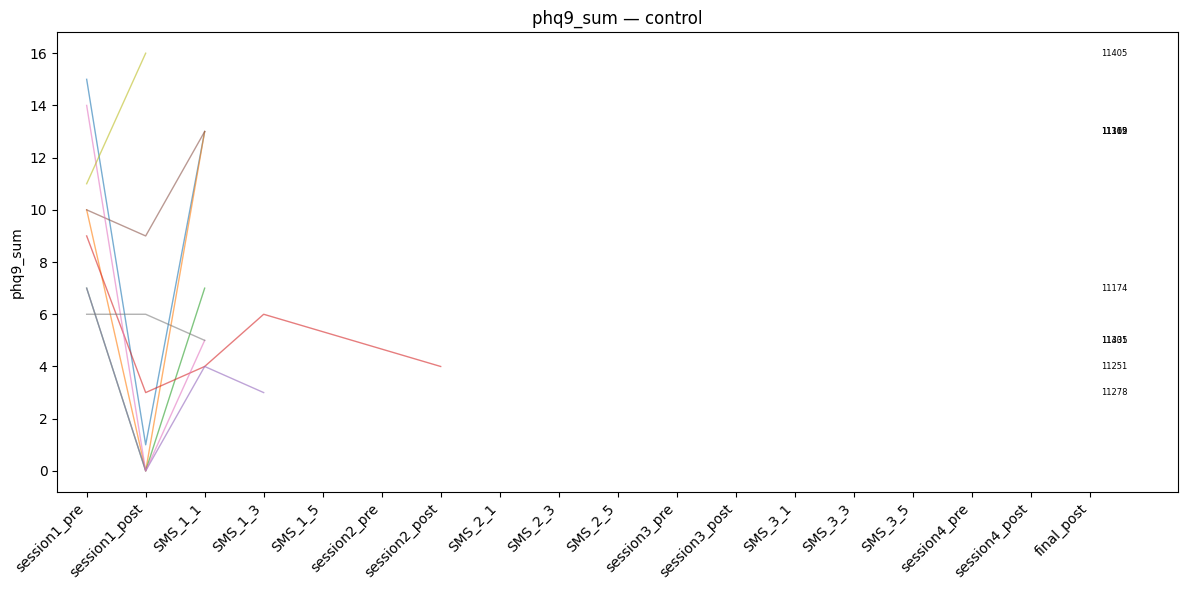

Worsened trajectories:


,part_id,timepoint,phq9_sum
0,11162,session1_pre,10.0
1,11162,session1_post,0.0
2,11162,SMS_1_1,13.0
3,11162,NaN,17.0
4,11309,session1_pre,10.0
5,11309,session1_post,9.0
6,11309,SMS_1_1,13.0
7,11309,NaN,17.0
8,11405,session1_pre,11.0
9,11405,session1_post,16.0



── phq9_sum  |  Condition: intervention ──


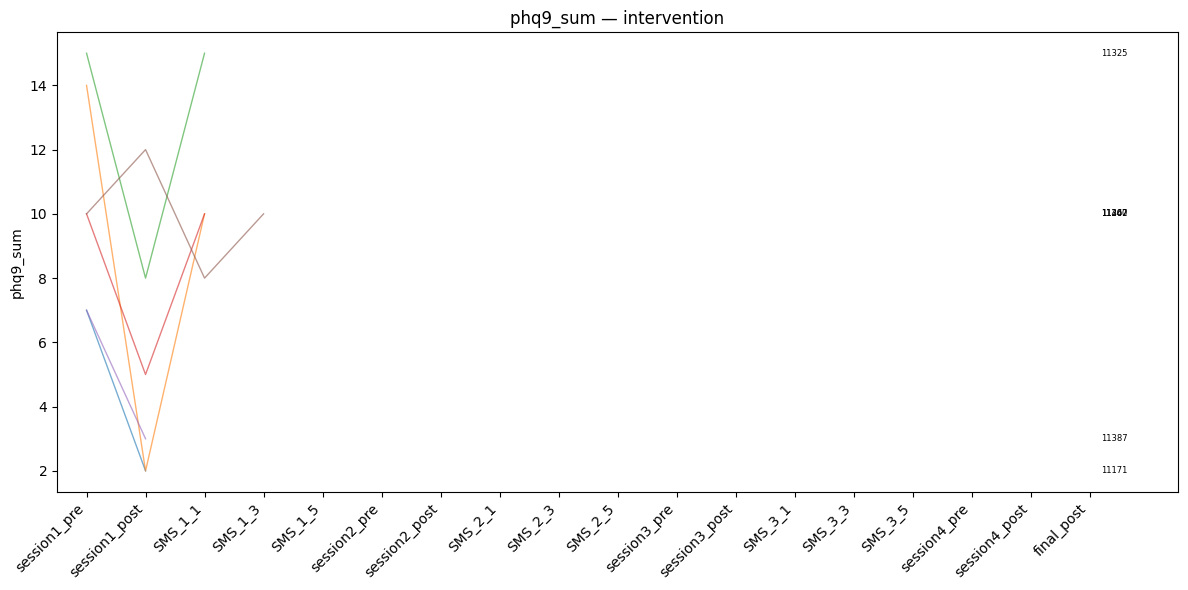

No worsening in this condition.

── spane_p  |  Condition: control ──


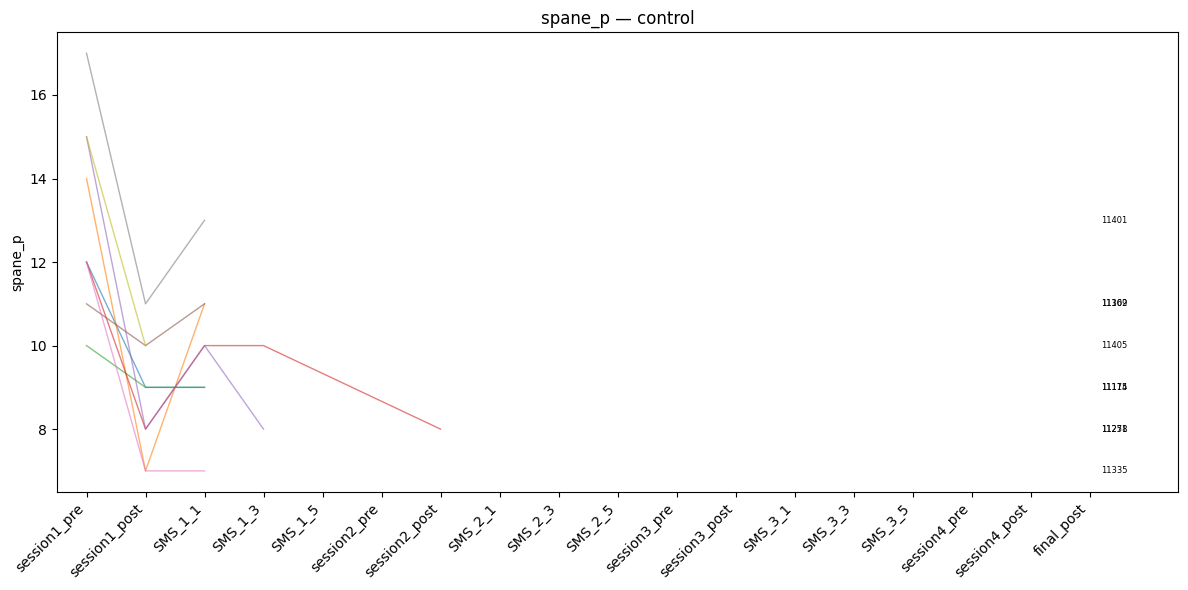

Worsened trajectories:


,part_id,timepoint,spane_p
0,11115,session1_pre,12.0
1,11115,session1_post,9.0
2,11115,SMS_1_1,9.0
3,11115,NaN,12.0
4,11162,session1_pre,14.0
5,11162,session1_post,7.0
6,11162,SMS_1_1,11.0
7,11162,NaN,11.0
8,11174,session1_pre,10.0
9,11174,session1_post,9.0



── spane_p  |  Condition: intervention ──


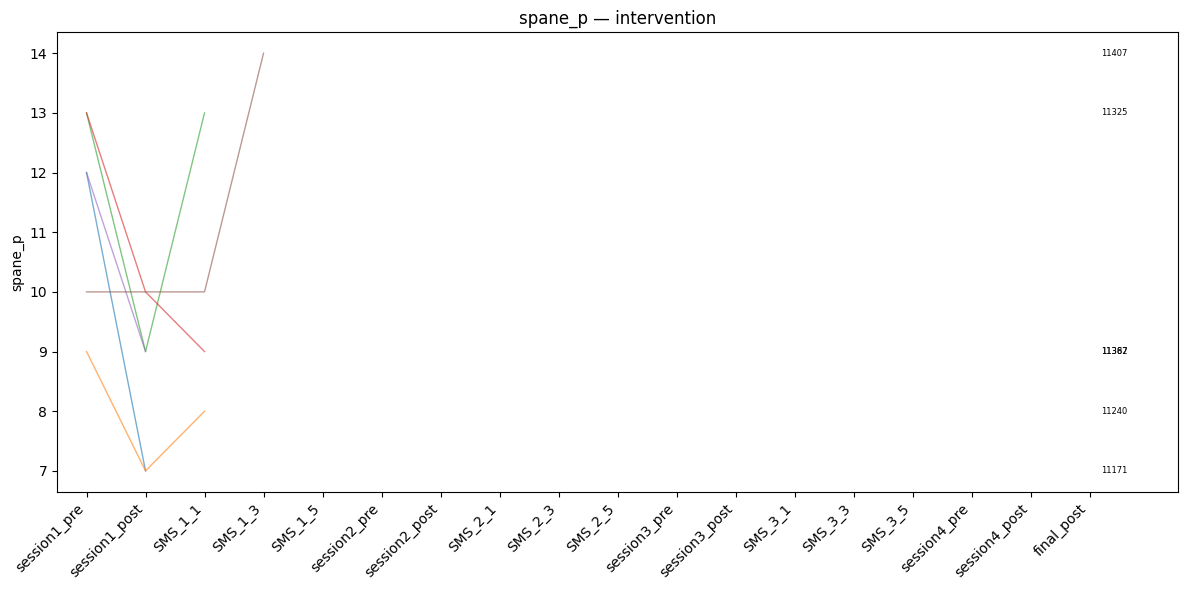

Worsened trajectories:


,part_id,timepoint,spane_p
0,11171,session1_pre,12.0
1,11171,session1_post,7.0
2,11240,session1_pre,9.0
3,11240,session1_post,7.0
4,11240,SMS_1_1,8.0
5,11362,session1_pre,13.0
6,11362,session1_post,10.0
7,11362,SMS_1_1,9.0
8,11387,session1_pre,12.0
9,11387,session1_post,9.0



── spane_n  |  Condition: control ──


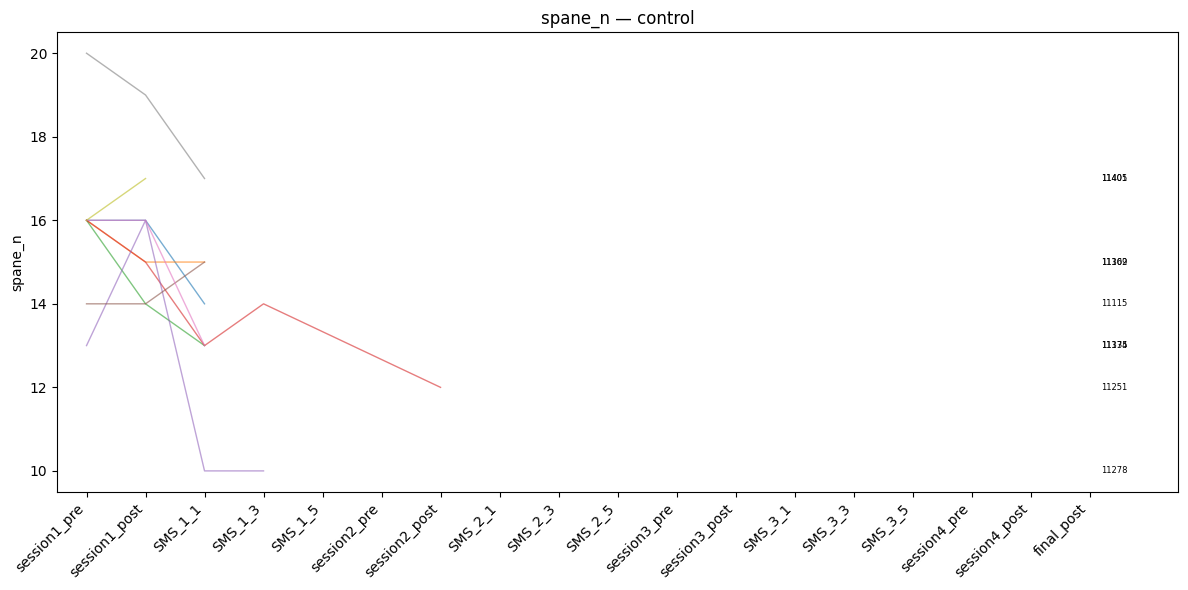

Worsened trajectories:


,part_id,timepoint,spane_n
0,11309,session1_pre,14.0
1,11309,session1_post,14.0
2,11309,SMS_1_1,15.0
3,11309,NaN,13.0
4,11405,session1_pre,16.0
5,11405,session1_post,17.0
6,11405,NaN,16.0



── spane_n  |  Condition: intervention ──


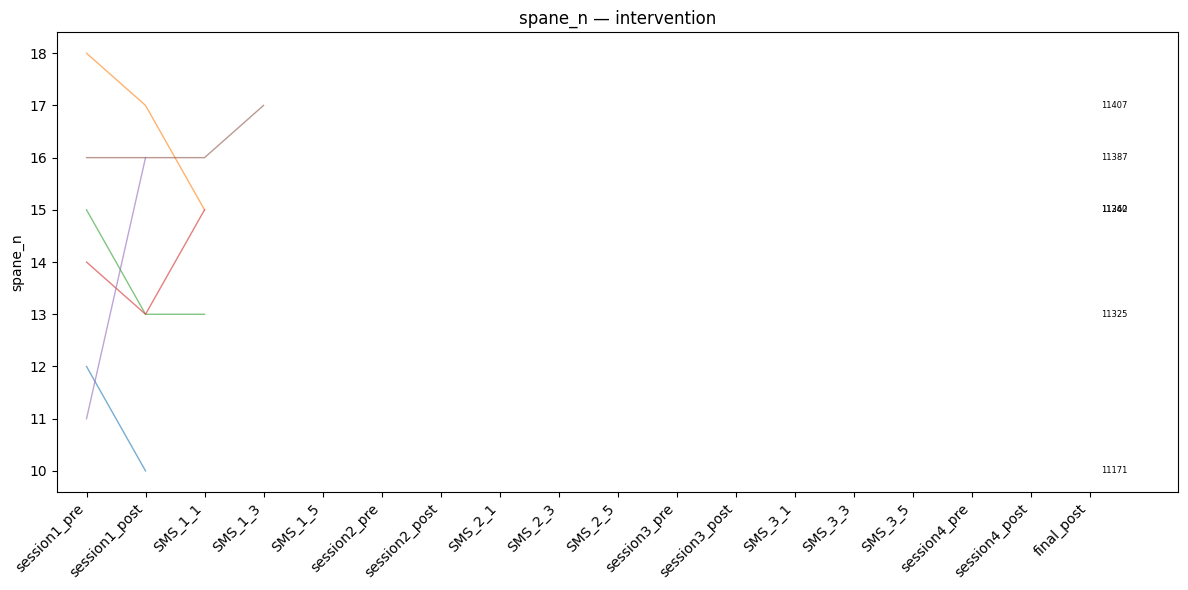

Worsened trajectories:


,part_id,timepoint,spane_n
0,11362,session1_pre,14.0
1,11362,session1_post,13.0
2,11362,SMS_1_1,15.0
3,11387,session1_pre,11.0
4,11387,session1_post,16.0
5,11407,session1_pre,16.0
6,11407,session1_post,16.0
7,11407,SMS_1_1,16.0
8,11407,SMS_1_3,17.0
9,11407,NaN,17.0



── m3vas_mood  |  Condition: control ──


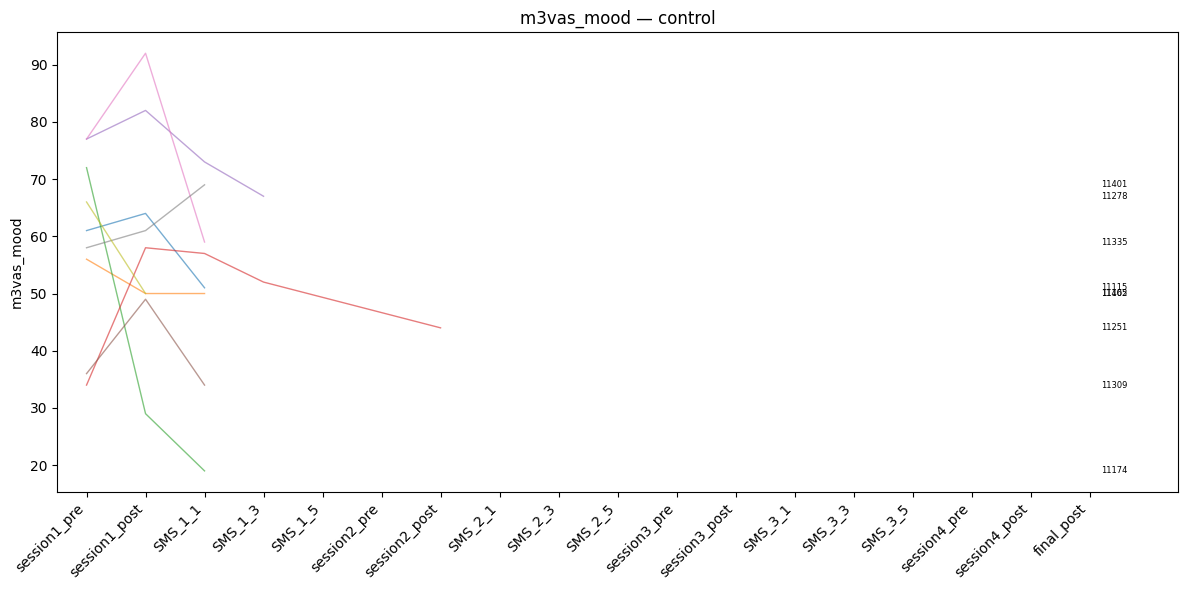

Worsened trajectories:


,part_id,timepoint,m3vas_mood
0,11115,session1_pre,61.0
1,11115,session1_post,64.0
2,11115,SMS_1_1,51.0
3,11115,NaN,20.0
4,11162,session1_pre,56.0
5,11162,session1_post,50.0
6,11162,SMS_1_1,50.0
7,11162,NaN,50.0
8,11174,session1_pre,72.0
9,11174,session1_post,29.0



── m3vas_mood  |  Condition: intervention ──


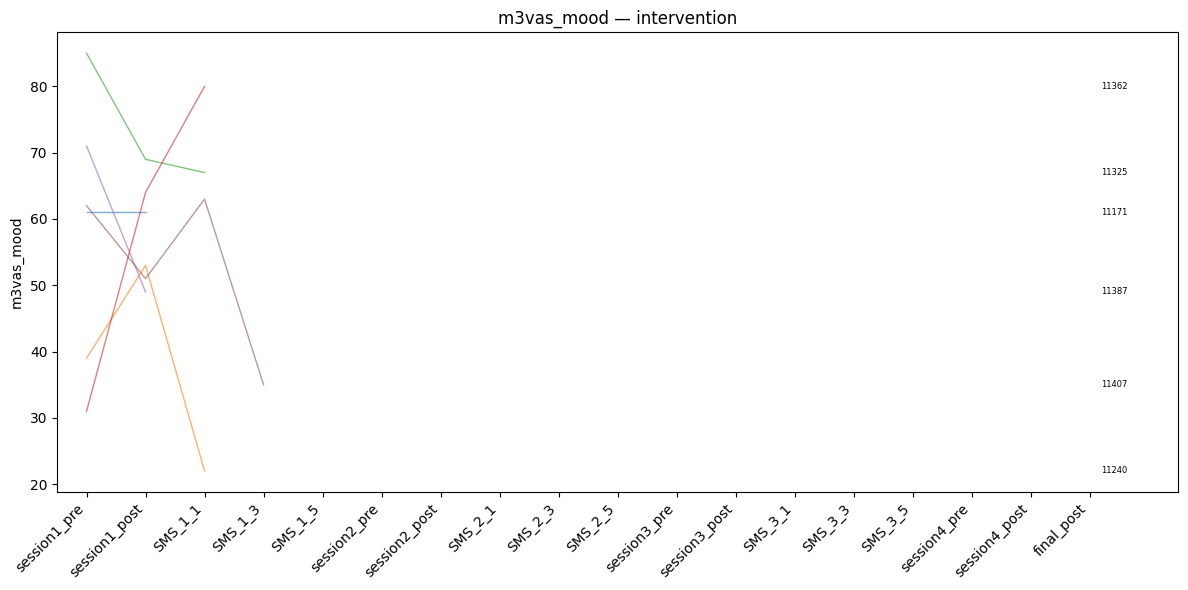

Worsened trajectories:


,part_id,timepoint,m3vas_mood
0,11240,session1_pre,39.0
1,11240,session1_post,53.0
2,11240,SMS_1_1,22.0
3,11325,session1_pre,85.0
4,11325,session1_post,69.0
5,11325,SMS_1_1,67.0
6,11325,NaN,71.0
7,11387,session1_pre,71.0
8,11387,session1_post,49.0
9,11407,session1_pre,62.0



── m3vas_pleasure  |  Condition: control ──


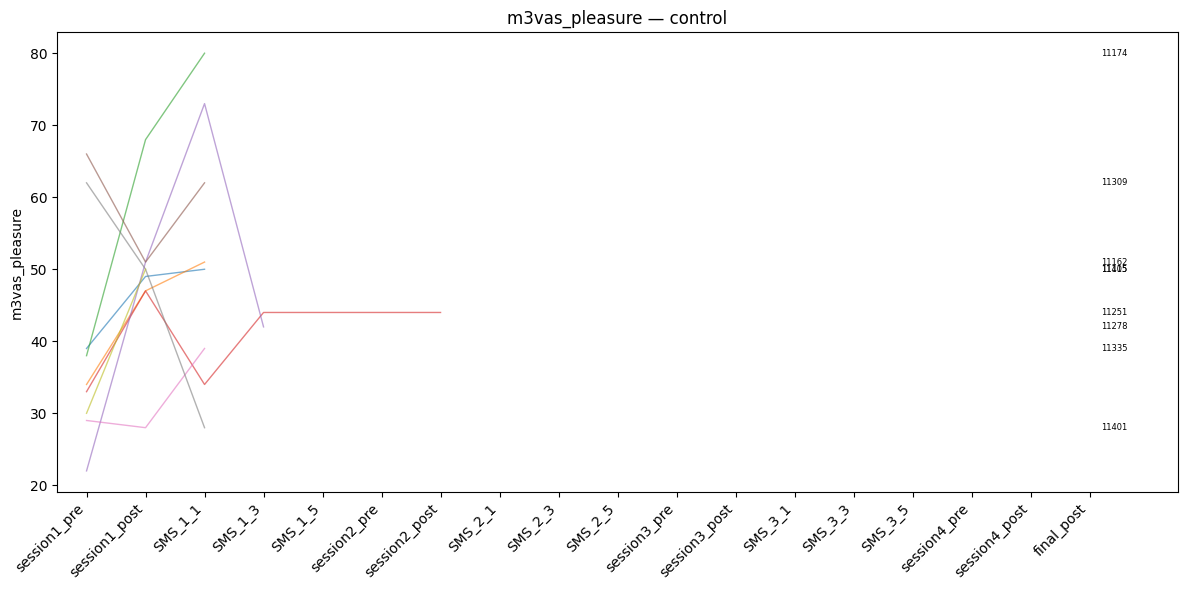

Worsened trajectories:


,part_id,timepoint,m3vas_pleasure
0,11309,session1_pre,66.0
1,11309,session1_post,51.0
2,11309,SMS_1_1,62.0
3,11309,NaN,76.0
4,11401,session1_pre,62.0
5,11401,session1_post,50.0
6,11401,SMS_1_1,28.0
7,11401,NaN,38.0



── m3vas_pleasure  |  Condition: intervention ──


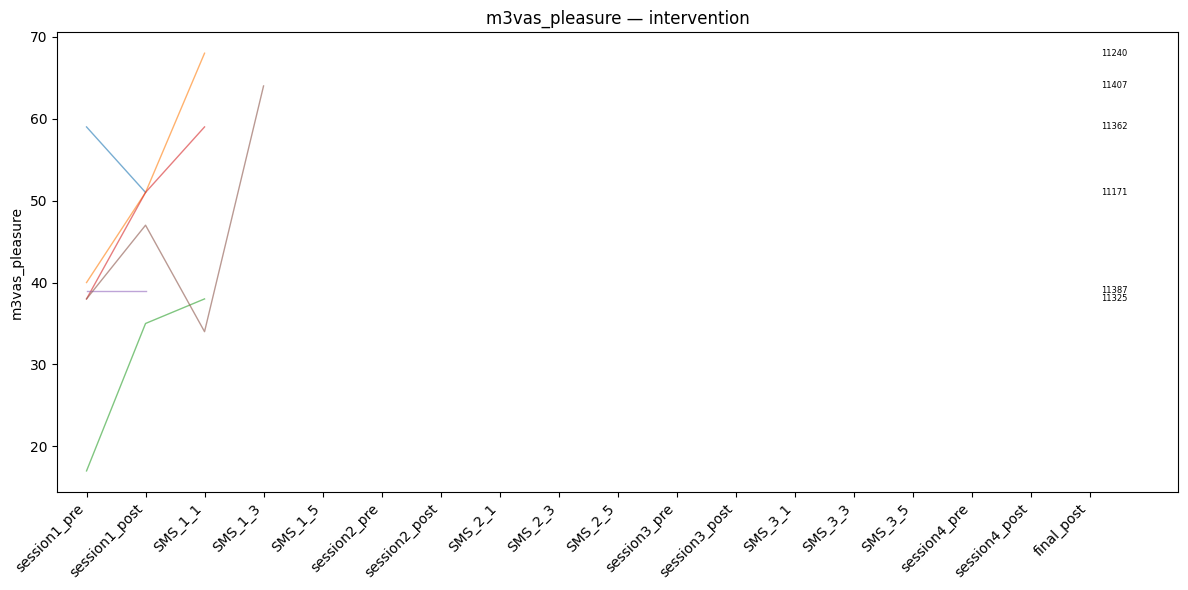

Worsened trajectories:


,part_id,timepoint,m3vas_pleasure
0,11171,session1_pre,59.0
1,11171,session1_post,51.0



── m3vas_suicidal  |  Condition: control ──


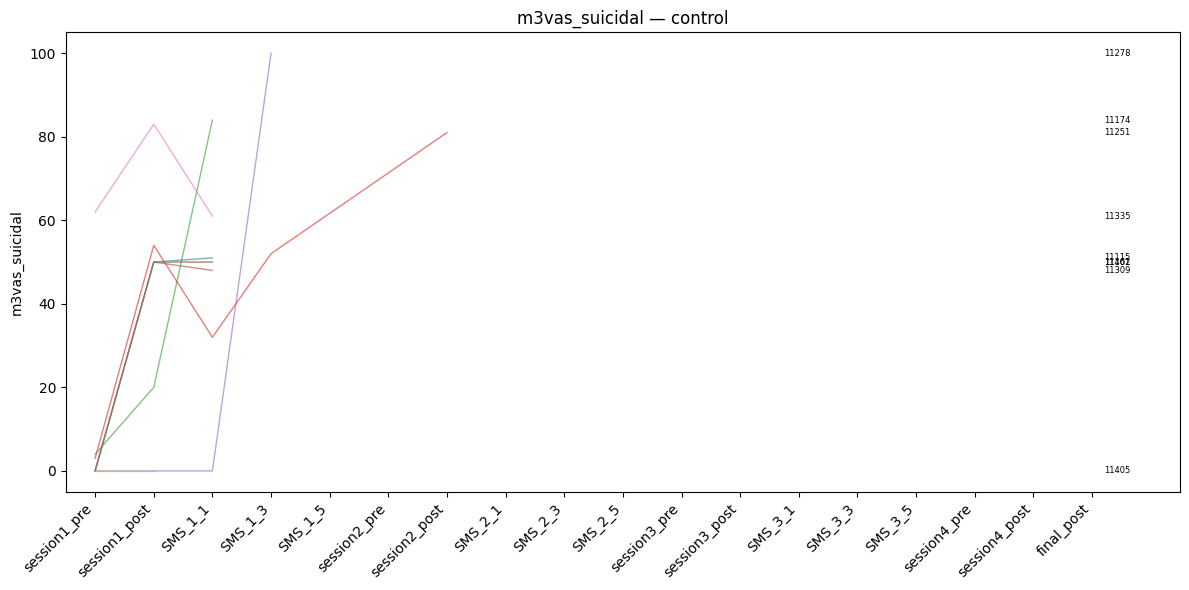

Worsened trajectories:


,part_id,timepoint,m3vas_suicidal
0,11115,session1_pre,0.0
1,11115,session1_post,50.0
2,11115,SMS_1_1,51.0
3,11115,NaN,50.0
4,11162,session1_pre,0.0
5,11162,session1_post,50.0
6,11162,SMS_1_1,50.0
7,11162,NaN,50.0
8,11174,session1_pre,4.0
9,11174,session1_post,20.0



── m3vas_suicidal  |  Condition: intervention ──


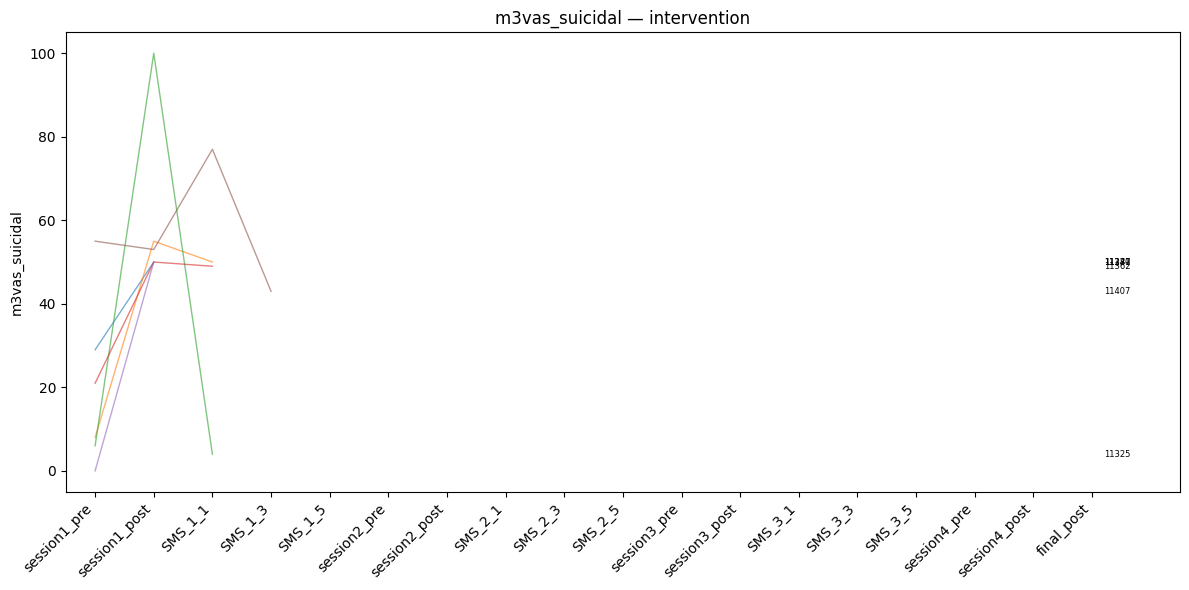

Worsened trajectories:


,part_id,timepoint,m3vas_suicidal
0,11171,session1_pre,29.0
1,11171,session1_post,50.0
2,11240,session1_pre,8.0
3,11240,session1_post,55.0
4,11240,SMS_1_1,50.0
5,11362,session1_pre,21.0
6,11362,session1_post,50.0
7,11362,SMS_1_1,49.0
8,11387,session1_pre,0.0
9,11387,session1_post,50.0


→ skipping 'fisber_1': not in df_long
→ skipping 'fisber_2': not in df_long
→ skipping 'fisber_3': not in df_long

── bai_sum  |  Condition: control ──


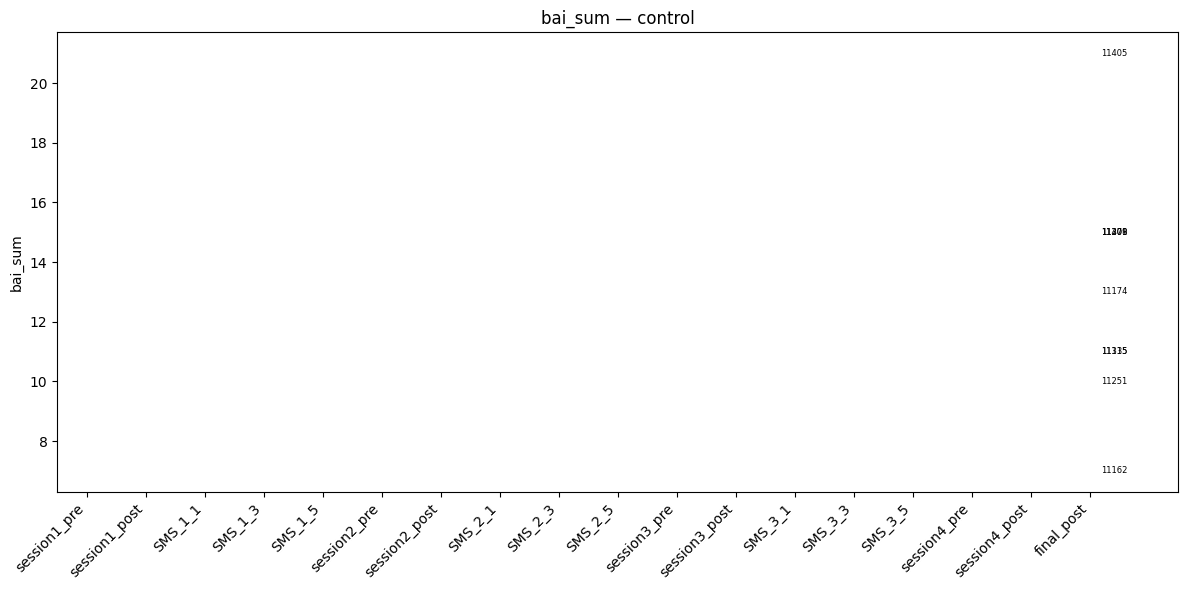

No worsening in this condition.

── bai_sum  |  Condition: intervention ──


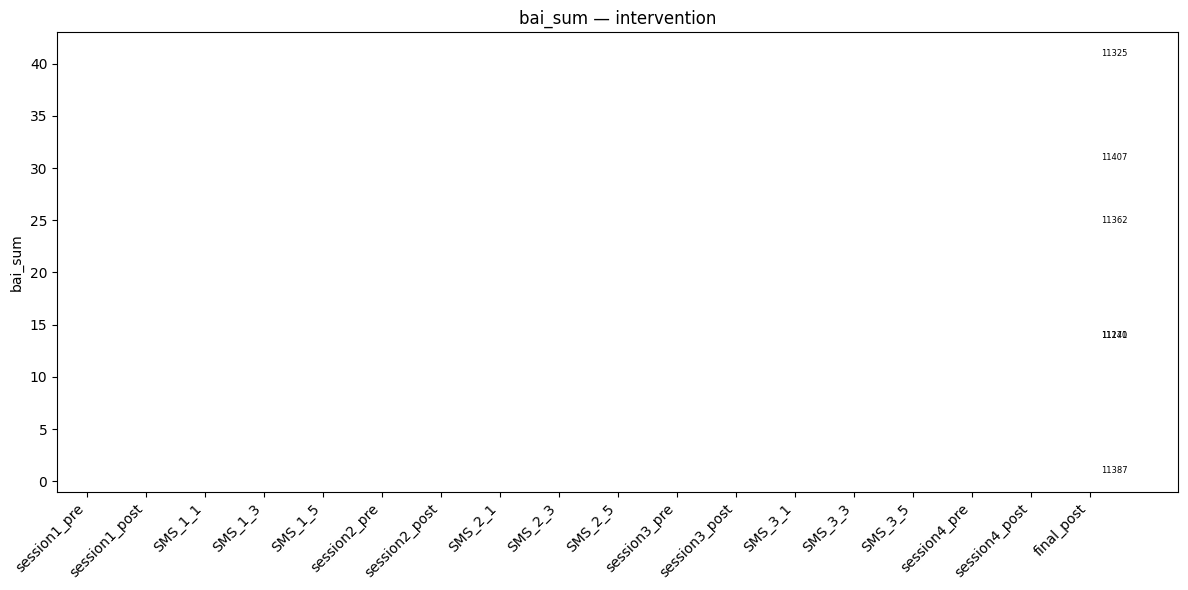

No worsening in this condition.

── bdi_sum  |  Condition: control ──


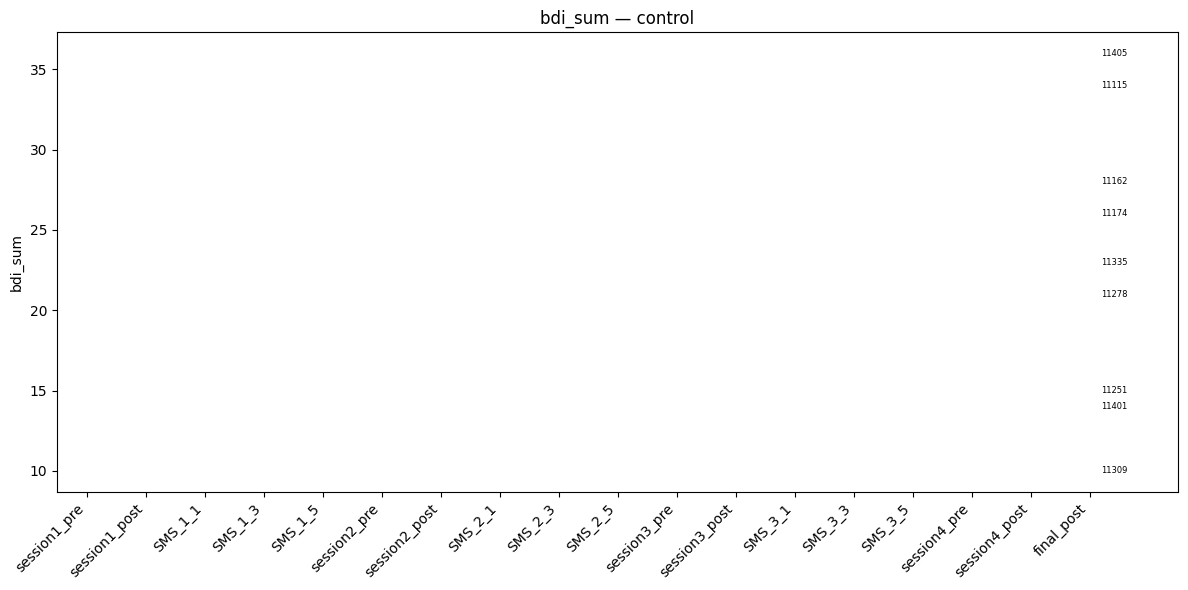

No worsening in this condition.

── bdi_sum  |  Condition: intervention ──


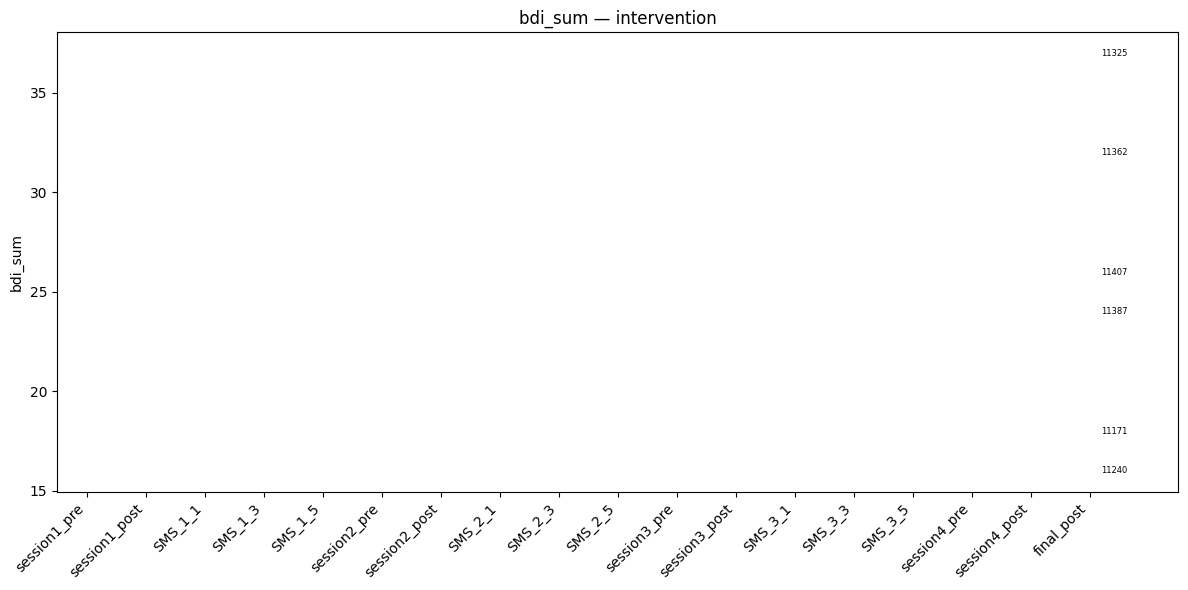

No worsening in this condition.

── MADRS_S_sum  |  Condition: control ──


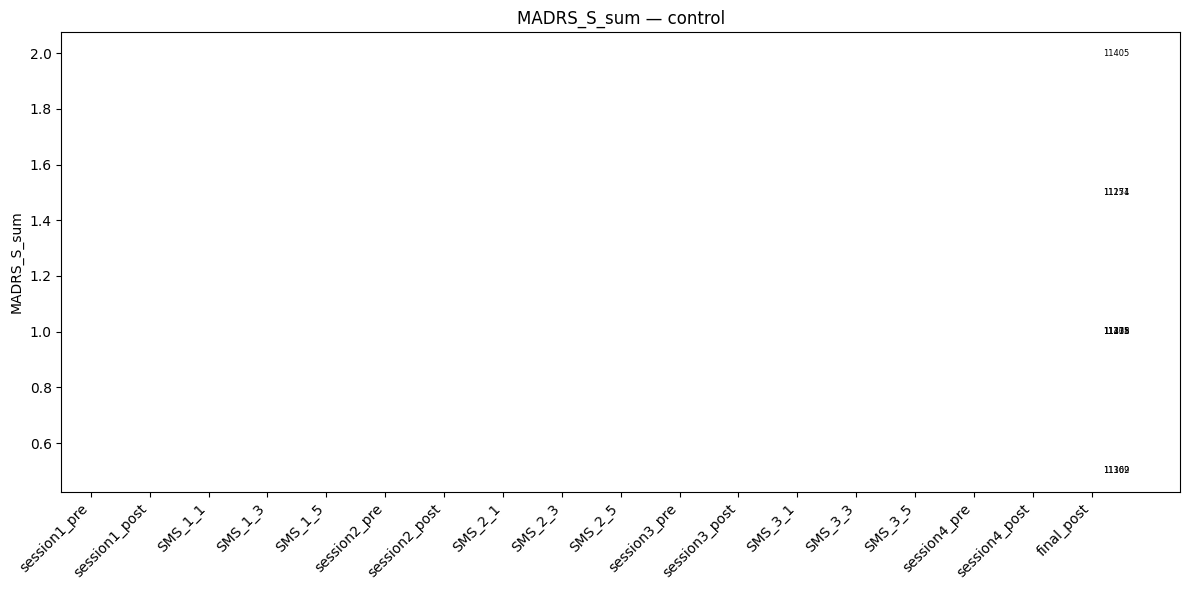

No worsening in this condition.

── MADRS_S_sum  |  Condition: intervention ──


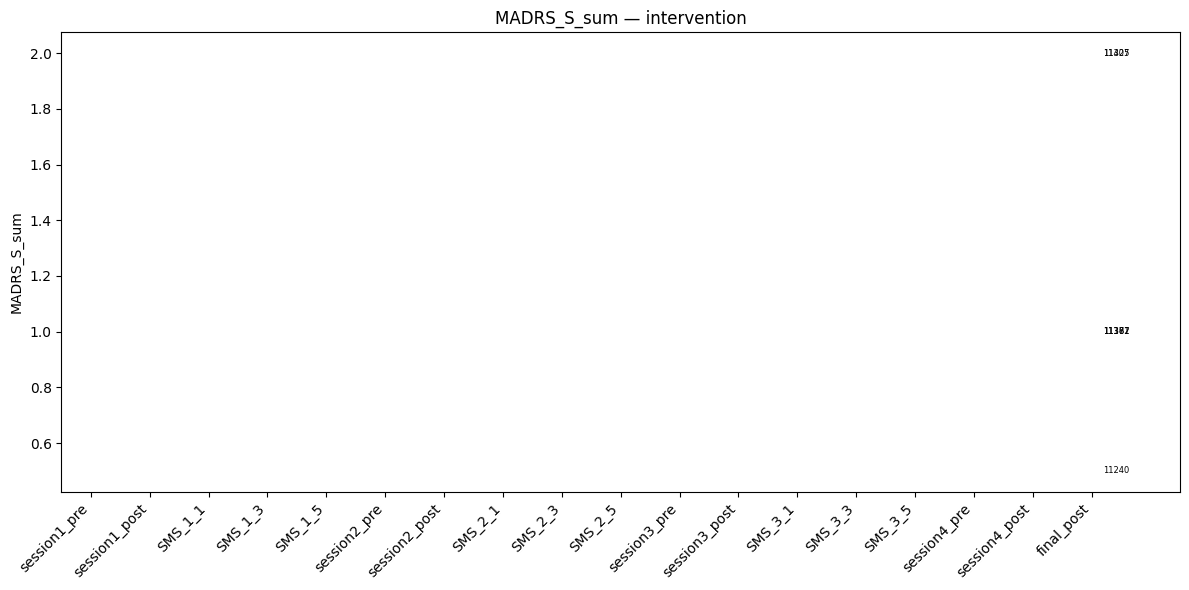

No worsening in this condition.


In [7]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')
df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    # invert pleasure
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    # drop raw/input cols
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_3','SMS_1_5',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_3','SMS_2_5',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_3','SMS_3_5',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING BY CONDITION
#####
bad_if_higher = {
    'phq9_sum','spane_n','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
}
bad_if_lower = {'spane_p','m3vas_mood','m3vas_pleasure'}

def plot_and_flag_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    for cond, dfc in df_long.groupby('condition', dropna=False):
        print(f"\n── {measure}  |  Condition: {cond} ──")
        fig, ax = plt.subplots(figsize=(12,6))
        x_final = len(ordered_timepoints) - 1

        for pid, grp in dfc.groupby('part_id'):
            s = grp.dropna(subset=['timepoint', measure]) \
                   .sort_values('timepoint')
            if s.empty:
                continue
            x = s['timepoint'].cat.codes
            y = s[measure].astype(float)
            ax.plot(x, y, linewidth=1, alpha=0.6)
            ax.text(x_final + 0.2, y.iloc[-1], pid, fontsize=6, va='center')

        ax.set_xlim(-0.5, x_final + 1.5)
        ax.set_xticks(range(len(ordered_timepoints)))
        ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
        ax.set_ylabel(measure)
        ax.set_title(f"{measure} — {cond}")
        plt.tight_layout()
        plt.show()

        # Flag worsened participants
        worsened = []
        for pid, grp in dfc.groupby('part_id'):
            seq = (grp
                   .dropna(subset=['timepoint', measure])
                   .sort_values('timepoint')[measure]
                   .astype(float))
            if len(seq) < 2:
                continue
            if ((measure in bad_if_higher and seq.iloc[-1] > seq.iloc[0]) or
                (measure in bad_if_lower and seq.iloc[-1] < seq.iloc[0])):
                worsened.append(pid)

        if worsened:
            df_flagged = (
                dfc[dfc['part_id'].isin(worsened)]
                  .loc[:, ['part_id','timepoint', measure]]
                  .dropna(subset=[measure])
                  .sort_values(['part_id','timepoint'])
                  .reset_index(drop=True)
            )
            print("Worsened trajectories:")
            display(df_flagged)
        else:
            print("No worsening in this condition.")

#####
# 15) RUN PLOTS FOR ALL MEASURES
#####
measures = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for m in measures:
    plot_and_flag_by_condition(m)

Mean Tolerability ± SD Assessment Across Sessions (Whole-Sample & Just-Adverse)
*   run previous monitoring and stratification scripts first to generate necessary dfs

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

#####
# 0) Load and clean all post-session data (sessions 1–4)
#####
from pathlib import Path
import glob

DATA_DIR = Path('/content')
# Glob all post-session CSVs (e.g. sessions 1-3 and session 4)
post_files = sorted(str(f) for f in DATA_DIR.glob('wp2_post_session*csv'))

# Read each file, skip metadata row, and assign timepoint
frames = []
for fpath in post_files:
    temp = pd.read_csv(fpath, header=0, skiprows=[1], dtype=str)
    temp.columns = temp.columns.str.strip()
    temp['part_id'] = temp['part_id'].astype(str).str.strip()
    # If session_n column present, map it
    if 'session_n' in temp.columns:
        temp['session_n'] = pd.to_numeric(temp['session_n'], errors='coerce')
        temp['timepoint'] = temp['session_n'].apply(lambda x: f'session{int(x)}_post' if pd.notna(x) else None)
    else:
        # infer session4_post from filename
        temp['timepoint'] = 'session4_post'
    frames.append(temp)

# Concatenate all sessions
df_raw = pd.concat(frames, ignore_index=True)

#####
# 1) Compute tol_score (max across all tol_follow items)
##### tol_score per row (max across all tol_follow items)
#####
tol_cols = [c for c in df_raw.columns if c.lower().startswith('tol_follow')]
for col in tol_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce').fillna(0)

df_raw['tol_score'] = df_raw[tol_cols].max(axis=1)

#####
# 2) Merge in condition assignments
#####
assign = pd.read_csv('wp2_assignments.csv', dtype=str)[['part_id','condition']]
df = df_raw.merge(assign, on='part_id', how='left')

#####
# 3) Summarize per-participant-session
#####
tol_summary = (
    df
      .groupby(['part_id','condition','timepoint'], observed=False)
      .agg(tol_score=('tol_score', 'max'))
      .reset_index()
)

#####
# 4a) Mean ± SD including zeros, by arm and session
#####
tol_stats_all = (
    tol_summary
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_all=('tol_score', 'mean'),
          tol_sd_all=('tol_score', 'std')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score including zeros (mean ± SD), by condition and session:")
display(
    tol_stats_all.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_all','tol_sd_all']
    )
)

#####
# 4b) Mean ± SD & N among those with any side effect (tol_score > 0)
#####
tol_stats_nonzero = (
    tol_summary[tol_summary['tol_score'] > 0]
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_nonzero=('tol_score', 'mean'),
          tol_sd_nonzero=('tol_score', lambda x: x.std(ddof=0)),
          n_side_effects=('tol_score', 'count')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score among those with side effects (mean ± SD, N), by condition and session:")
display(
    tol_stats_nonzero.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_nonzero','tol_sd_nonzero','n_side_effects']
    )
)


Tolerability score including zeros (mean ± SD), by condition and session:


tol_mean_all                                            \
timepoint    session1_post session2_post session3_post session4_post   
condition                                                              
intervention           8.0           7.0           9.0           8.0   

                tol_sd_all                                            
timepoint    session1_post session2_post session3_post session4_post  
condition                                                             
intervention           NaN           NaN           NaN           NaN

Tolerability score among those with side effects (mean ± SD, N), by condition and session:


tol_mean_nonzero                                            \
timepoint       session1_post session2_post session3_post session4_post   
condition                                                                 
intervention              8.0           7.0           9.0           8.0   

             tol_sd_nonzero                                            \
timepoint     session1_post session2_post session3_post session4_post   
condition                                                               
intervention            0.0           0.0           0.0           0.0   

             n_side_effects                                            
timepoint     session1_post session2_post session3_post session4_post  
condition                                                              
intervention            1.0           1.0           1.0           1.0